In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from ERANataf import ERANataf
from ERADist import ERADist


# Problem description
    ## Problem
    ### Input: Capacity R~ Lognormal(mu_R=10,sigma_R=1.5),load S~Gumbel(mu_S = 5,sigma_S = 2)
    ### Model limit state function g(R,S) = R -S 
    ### Quantity of interest: Q = Pr(g(R,S)<0
    
    ## Method
    ### The Q_exact = 0.0331 (using the FORM can get the value analytically)
    ### Try to use Monte Carlo Simulation( MCS ), Markov Chain Monte Carlo method(MCMC), the First Order Reliability method(FORM), the Important sampling method, the Cross-Entropy method(CE), the subset simulation (SuS) and the improved cross entropy method(iCE) to estimate the rare events probability and evaluate the quality of the esiimator and compare the method


In [2]:
## Parameter definition
mu_R = 10; sigma_R= 1.5
mu_S = 5; sigma_S = 2
R_pdf = ERADist("Lognormal","MOM",[mu_R, sigma_R])
S_pdf = ERADist("Gumbel","MOM",[mu_S,sigma_S])
# target distribution
f = lambda x: R_pdf.pdf(x[:,0])*S_pdf.pdf(x[:,1])
# Performance function
# g = lambda R,S: R-S
g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
# Threshold 
gamma = 0
Q_exact = 0.0331
dim = 2
np.random.seed(1)# For reproducibility

## Crude Monte Carlo Simulation(MCS)

In [3]:
## Monte Carlo Simulation 
N_MC = 1000
# Sample generation
x_MC = np.transpose([R_pdf.random(N_MC),S_pdf.random(N_MC)])
# Performance function
#g_MC = g(r_MC,s_MC)
g_MC = g(x_MC)
# Estimation of Q_MC 
Q_MC = sum(g_MC<=gamma)/N_MC
# Evaluation of Q_MC coefficient of variation delta
CV_MC = np.sqrt((1-Q_MC)/(Q_MC*N_MC))
Q_MC

0.03

In [4]:
x_MC.shape

(1000, 2)

## Markov Chain Monte Carlo method MCMC


In [5]:
## Markov Chain Monte Carlo simulation using the random walk sampler Metropolis-Hastings algorithm (M-H algorithm)

N_MCMC = 10000
# Sample generation
sp = [mu_R, mu_S]
sigma = 2.4
x = np.zeros((N_MCMC,2))
x[0,:] = sp
# generate z ~ N(0,sigma)
Sigma = np.eye(2)*sigma;
z = np.random.multivariate_normal([0,0],Sigma,N_MCMC)
# Uniform sample
u = np.random.uniform(0,1,N_MCMC)
for i in range(N_MCMC-1):
    # generate candidate
    y = x[i,:] + z[i,:]
    # evaluate the acceptance probability
    f_y = R_pdf.pdf(y[0])*S_pdf.pdf(y[1])
    f_x = R_pdf.pdf(x[i,0])*S_pdf.pdf(x[i,1])
    alpha = min(1,f_y/f_x)
    # check if sample should be accepted
    if u[i] <= alpha:
        x[i+1,:] = y
    else:
        x[i+1,:] = x[i,:]
# The performance of the samples
g_MCMC = x[:,0]-x[:,1]
I_MCMC = g_MCMC < gamma
Q_MCMC = sum(I_MCMC)/len(g_MCMC)
Q_MCMC
# nlags = 50
#acf = np.correlate(I_MCMC,I_MCMC,mode='full')
#delta = 2*sum(1)
#CV_MCMC = np.var(I_MCMC)/N_MCMC*(1+delta)           
## Comment MCMC needs more samples to reach the same level of accuracy as the MCS
    
    

0.0246

## First order reliability method FORM


In [6]:
## First Order reliability method (FORM) 
# First transform to the standard uniform space
# Distribution object
M = [ERADist("Lognormal","MOM",[mu_R, sigma_R]),ERADist("Gumbel","MOM",[mu_S,sigma_S])]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
# N_FORM
# Performance function in Physical space g = R-S
g = lambda x: x[:,0]-x[:,1] # x: Nxdim
#g = lambda x: x[1,:]-x[0,:]
# Performance function in transformed space G = g
# Gradient in physical space dg/dR=1 dg/dS=-1 dg = [] 
dg = lambda x: [1,-1]
#dg = lambda x: [-1,1]
# Gradient in transformed space dG = dg/det(Jac)
# Design point in the transformed domain
u0 = [0,0];
# Maximum number of steps
maxi = 100;
u = np.zeros((dim,maxi))
u[:,0]=u0
for i in range(maxi):
    [x_i,Jac] = T_Nataf.U2X(u[:,i].reshape(2,1),Jacobian=True)
    g_i = g(np.transpose(x_i))
    G_i = g_i
    dg_i = dg(x_i)
    dG_i = np.dot(dg_i,np.linalg.inv(Jac))
    d_i = 1/np.power(np.linalg.norm(dG_i),2)*(np.dot(dG_i,u[:,i])-G_i)*np.transpose(dG_i)-u[:,i]
    u[:,i+1] = u[:,i]+d_i
    if np.linalg.norm(d_i)<1.e-5:
        ustar = u[:,i]
        break
beta = np.linalg.norm(ustar)
import scipy as sp
Q_FORM = sp.stats.norm.cdf(-beta)
-beta
Q_FORM # analytical solution

0.03314473756635762

## Importance sampling method
    # IS density is predefined
    # IS density based on the result of the FORM (the design point ustar in the transfromed space) h(u) = phi(u-ustar), mean is ustar Cov is identity matrix
    # IS density is found by the Variance minimisation method
    
    # IS density is found by the CE method (analytical closed form is available for the exponential parametric family)
        # IS density is found by IS-MCS
        # IS denstiy is found by IS-IS
            # Self version           
            # Full version
    # IS density is found by the improved CE method
            
          
        

## Importance sampling method
    # IS density is predefined

In [7]:
## Importance sampling method (Choose the IS density through the cross entropy method)
# IS density using the cross entropy method
# number of samples per level
N_CE = 1000
# Quantile value to select samples for parameter update
p = 0.3
# limit state function in physical space
g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [ERADist("Lognormal","MOM",[mu_R, sigma_R]),ERADist("Gumbel","MOM",[mu_S,sigma_S])]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
dim = len(T_Nataf.Marginals)
u2x = lambda u: T_Nataf.U2X(u)
# Limist state function in standard space
G_LSF = lambda u: g(u2x(u))
# Initialization of variables and storage
j = 0 # initial level
maxT = 50 # estimated number of iterations
N_tot = 0 # total number of samples
mu_X = [mu_R, mu_S]
Cov_X = [[np.power(sigma_R,2), 0], [0, np.power(sigma_S,2)]]
for t in range(maxT):
    # Generate samples from the current IS density
    x_CE = sp.stats.multivariate_normal.rvs(mean=mu_X,cov = Cov_X,size=N_CE)
    # Evaluate the responses
    g_CE = g(x_CE)
    # Sort the responses
    g_CE_sort = np.sort(g_CE)
    # Estimate gamma_t
    gamma_t = max(g_CE_sort[int((1-p)*N_CE)],gamma)
    # Solve the CE optimization problem using the MCS or IS method
    # If we use MCS method we will not need additional weights

    # update parameters
    I_CE = g_CE< gamma_t
    mu_X = sum((I_CE).reshape(1000,1)*x_CE)/sum(I_CE)
    Xtmp = I_CE.reshape(1000,1)*x_CE-mu_X
    Xo = (Xtmp)*np.transpose(np.tile(np.sqrt(I_CE),(dim,1)))
    Cov_X = np.dot(np.transpose(Xo),Xo)/sum(I_CE)+1e-6*np.identity(dim)
    
    # If we use IS method we need additional weights  
    
    # Check if the final level is reached
    if gamma_t == gamma:
        break
# Generate samples from the final distribution
N_final = 1000
x_CE = sp.stats.multivariate_normal.rvs(mean=mu_X,cov = Cov_X,size=N_final)
# Evaluate the performance 
g_CE = g(x_CE)
# Evaluate the weight
f_CE = f(x_CE)
h_CE = sp.stats.multivariate_normal.pdf(x_CE,mu_X,Cov_X)
w_CE = f_CE/h_CE
# Evaluate the Pr
Q_CE1 = sum(I_CE*w_CE)/N_final
# Quality of the estimator
Var_CE1 = np.var(I_CE*w_CE)/N_final
CV_CE1 = np.sqrt(Var_CE1)/Q_CE1
Q_CE1


0.0002358016902179167

## Importance sampling method
    # IS density based on the result of the FORM (the design point ustar in the transfromed space) h(u) = phi(u-ustar), mean is ustar Cov is identity matrix

In [8]:
## Importance sampling method (Choose the IS density centered at the design point)
N_IS = 1000
# IS density
# In the transformed space h(u) = multivariate normal distribution(u-ustar)
mu_u = ustar
Cov_u = np.identity(dim)
#mu_u = [9,9]
#Cov_u = 2*np.identity(dim)
h = lambda u: sp.stats.multivariate_normal.pdf(u,mean=mu_u,cov = Cov_u)
# Generate samples from IS density h
u_IS =  sp.stats.multivariate_normal.rvs(mean=mu_u,cov = Cov_u,size=N_IS)
x_IS =  T_Nataf.U2X(u_IS.reshape(2,1000)).reshape(N_IS,dim)
w_IS = f(x_IS)/h(u_IS)
# Evaluate the performance function
g_IS = g(x_IS)
# Estimate the Pr(P<0)
I_IS = g_IS < gamma
Q_IS = sum(I_IS*w_IS)/N_IS
Q_IS

0.00798079729701033

## Importance sampling method
    # IS density is found by the Variance minimisation method

In [9]:
## Importance sampling method (Choose the IS density through the variance minimisation method)

## Importance sampling method   
    # IS density is found by the CE method (analytical closed form is available for the exponential parametric family)
        # IS density is found by IS-MCS
      


In [10]:
## Importance sampling method (Choose the IS density through the cross entropy method)
# IS density using the cross entropy method
# number of samples per level
N_CE = 1000
# Quantile value to select samples for parameter update
p = 0.3
# limit state function in physical space
g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [ERADist("Lognormal","MOM",[mu_R, sigma_R]),ERADist("Gumbel","MOM",[mu_S,sigma_S])]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
dim = len(T_Nataf.Marginals)
u2x = lambda u: T_Nataf.U2X(u)
# Limist state function in standard space
G_LSF = lambda u: g(u2x(u))
# Initialization of variables and storage
j = 0 # initial level
maxT = 50 # estimated number of iterations
N_tot = 0 # total number of samples
mu_X = [mu_R, mu_S]
Cov_X = [[np.power(sigma_R,2), 0], [0, np.power(sigma_S,2)]]
for t in range(maxT):
    # Generate samples from the current IS density
    x_CE = sp.stats.multivariate_normal.rvs(mean=mu_X,cov = Cov_X,size=N_CE)
    # Evaluate the responses
    g_CE = g(x_CE)
    # Sort the responses
    g_CE_sort = np.sort(g_CE)
    # Estimate gamma_t
    gamma_t = max(g_CE_sort[int((1-p)*N_CE)],gamma)
    # Solve the CE optimization problem using the MCS or IS method
    # If we use MCS method we will not need additional weights

    # update parameters
    I_CE = g_CE< gamma_t
    mu_X = sum((I_CE).reshape(1000,1)*x_CE)/sum(I_CE)
    Xtmp = I_CE.reshape(1000,1)*x_CE-mu_X
    Xo = (Xtmp)*np.transpose(np.tile(np.sqrt(I_CE),(dim,1)))
    Cov_X = np.dot(np.transpose(Xo),Xo)/sum(I_CE)+1e-6*np.identity(dim)
    
    # If we use IS method we need additional weights  
    
    # Check if the final level is reached
    if gamma_t == gamma:
        break
# Generate samples from the final distribution
N_final = 1000
x_CE = sp.stats.multivariate_normal.rvs(mean=mu_X,cov = Cov_X,size=N_final)
# Evaluate the performance 
g_CE = g(x_CE)
# Evaluate the weight
f_CE = f(x_CE)
h_CE = sp.stats.multivariate_normal.pdf(x_CE,mu_X,Cov_X)
w_CE = f_CE/h_CE
# Evaluate the Pr
Q_CE1 = sum(I_CE*w_CE)/N_final
# Quality of the estimator
Var_CE1 = np.var(I_CE*w_CE)/N_final
CV_CE1 = np.sqrt(Var_CE1)/Q_CE1
Q_CE1


0.0002362279646701927

## Importance sampling method   
    # IS density is found by the CE method (analytical closed form is available for the exponential parametric family)
        # IS denstiy is found by IS-IS
            # Self version
            

In [11]:
## Importance sampling method (Choose the IS density through the cross entropy method)
# IS density using the cross entropy method
# number of samples per level
N_CE = 1000
# Quantile value to select samples for parameter update
p = 0.3
# limit state function in physical space
g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [ERADist("Lognormal","MOM",[mu_R, sigma_R]),ERADist("Gumbel","MOM",[mu_S,sigma_S])]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
dim = len(T_Nataf.Marginals)
u2x = lambda u: T_Nataf.U2X(u)
# Limist state function in standard space
G_LSF = lambda u: g(u2x(u))
# Initialization of variables and storage
j = 0 # initial level
maxT = 50 # estimated number of iterations
N_tot = 0 # total number of samples
mu_X = [mu_R, mu_S]
Cov_X = [[np.power(sigma_R,2), 0], [0, np.power(sigma_S,2)]]
for t in range(maxT):
    # Generate samples from the current IS density
    x_CE = sp.stats.multivariate_normal.rvs(mean=mu_X,cov = Cov_X,size=N_CE)
    # Evaluate the responses
    g_CE = g(x_CE)
    N_tot += N_CE
    # Sort the responses
    g_CE_sort = np.sort(g_CE)
    # Estimate gamma_t
    gamma_t = max(g_CE_sort[int(p*N_CE)],gamma)
    # Solve the CE optimization problem using the MCS or IS method
    # If we use MCS method we will not need additional weights
    # If we use IS method we need additional weights w_IS_IS  

    f_CE = f(x_CE)
    h_CE = sp.stats.multivariate_normal.pdf(x_CE,mu_X,Cov_X)
    w_IS_IS = f_CE/h_CE
    # update parameters
    I_CE = g_CE< gamma_t
    mu_X = sum((I_CE*w_IS_IS).reshape(1000,1)*x_CE)/sum(I_CE*w_IS_IS)
    Xtmp = I_CE.reshape(1000,1)*x_CE-mu_X
    Xo = (Xtmp)*np.transpose(np.tile(np.sqrt(w_IS_IS*I_CE),(dim,1)))
    Cov_X = np.dot(np.transpose(Xo),Xo)/sum(I_CE*w_IS_IS)+1e-6*np.identity(dim)    
    # Check if the final level is reached
    if gamma_t == gamma:
        break
N_final = 100
# Generate samples from the final distribution
x_CE = sp.stats.multivariate_normal.rvs(mean=mu_X,cov = Cov_X,size=N_final)
# Evaluate the performance 
g_CE = g(x_CE)
# Evaluate the weights
f_CE = f(x_CE)
h_CE = sp.stats.multivariate_normal.pdf(x_CE,mu_X,Cov_X)
w_CE = f_CE/h_CE
I_CE = g_CE < gamma
# Evaluate the Pr
Q_CE2 = sum(I_CE*w_CE)/N_final
# Quality of the estimator
Var_CE2 = np.var(I_CE*w_CE)/N_final
CV_CE2 = np.sqrt(Var_CE2)/Q_CE2
Q_CE2


0.033745680792705283

In [12]:
x_CE.shape

(100, 2)

## Importance sampling method   
    # IS density is found by the CE method (analytical closed form is available for the exponential parametric family)
        # IS denstiy is found by IS-IS
            # Full version

In [13]:
import numpy as np
import scipy as sp
from ERANataf import ERANataf
from ERADist import ERADist
## Parameter definition
mu_R = 10; sigma_R= 1.5
mu_S = 5; sigma_S = 2
R_pdf = ERADist("Lognormal","MOM",[mu_R, sigma_R])
S_pdf = ERADist("Gumbel","MOM",[mu_S,sigma_S])
# target distribution
f = lambda x: R_pdf.pdf(x[:,0])*S_pdf.pdf(x[:,1])
# Performance function
# g = lambda R,S: R-S
g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
# Threshold 
gamma = 0
Q_exact = 0.0331
dim = 2
np.random.seed(1)# For reproducibility
## Importance sampling method (Choose the IS density through the cross entropy method)
# IS density using the cross entropy method
# number of samples per level
N_CE = 1000
# Quantile value to select samples for parameter update
p = 0.3
# limit state function in physical space
g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [ERADist("Lognormal","MOM",[mu_R, sigma_R]),ERADist("Gumbel","MOM",[mu_S,sigma_S])]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
dim = len(T_Nataf.Marginals)
u2x = lambda u: T_Nataf.U2X(u)
# Limist state function in standard space
G_LSF = lambda u: g(u2x(u).T)
# Initialization of variables and storage
j = 0 # initial level
maxT = 100 # estimated number of iterations
N_tot = 0 # total number of samples
# Definition of parameters of the random variables (uncorrelated standard normal)
mu_init = np.zeros(dim)
Si_init = np.eye(dim)
gamma_hat = np.zeros((maxT + 1))
samplesU = list()
# CE procedure
# Initial parameters
gamma_hat[j]=1
mu_hat = mu_init
Si_hat = Si_init
# Iteration
for t in range(maxT):
    # Generate samples and save them
    U = sp.stats.multivariate_normal.rvs(mean = mu_hat,cov = Si_hat, size=N_CE).reshape(-1,dim)
    samplesU.append(U.T)
    # Count generated samples
    N_tot +=N_CE
    # Evaluate the limit state funtion
    geval = G_LSF(U.T)
    # Calculating h for the likelihood funtion
    h = sp.stats.multivariate_normal.pdf(U,mu_hat,Si_hat)
    # Check convergence
    if gamma_hat[t] == 0:
        break
    # obtaining estimator gamma
    gamma_hat[t+1] = np.maximum(0,np.nanpercentile(geval,p*100))
    print("\nIntermediate failure threshold: ",gamma_hat[t+1])
    # Indicator function
    I = geval <= gamma_hat[t+1]
    # Likelihood ratio
    W = (sp.stats.multivariate_normal.pdf(U,mean=np.zeros((dim)),cov = np.eye(dim))/h)
    # Parameter update: Closed-form update
    prod = np.matmul(W[I],U[I,:])
    summ = np.sum(W[I])
    mu_hat = (prod)/summ
    Xtmp = U[I,:]-mu_hat
    Xo = (Xtmp)*np.tile(np.sqrt(W[I]),(dim,1)).T
    Si_hat = np.matmul(Xo.T,Xo)/np.sum(W[I])+1e-6*np.eye(dim)
# needed steps
T_CE = t
#gamma_hat = gamma_hat[:,T_CE+1] # intermediate levels
# Calculation of the probability of failure
W_final = sp.stats.multivariate_normal.pdf(U,mean=np.zeros(dim),cov = np.eye(dim))/h
I_final = geval <= 0
Pr = 1/N_CE*sum(I_final*W_final)
k_fin = 1 # final number of gaussinas in the mixture
Pr


Intermediate failure threshold:  3.850472324051749

Intermediate failure threshold:  1.2869763406287138

Intermediate failure threshold:  0.0


0.035913389169843525

In [14]:
np.zeros((4)).shape

(4,)

In [15]:
np.zeros(4).shape

(4,)

In [21]:
def CEIS_SG(N,p,g_fun,distr):
    if isinstance(distr,ERANataf): #use Nataf transform (dependence)
        dim = len(distr.Marginals) # number of random variables(dimension)
        u2x = lambda u: distr.U2X(u) # from u to x
    elif isinstance(distr[0],ERADist):# use distribution information for the transformation (independence)
    # here we are assuming that all parameters have the same distribution 
    # Adjust accordingly otherwise
        dim = len(distr)# number of random variables(dimenstion)
        u2x = lambda u: distr[0].icdf(sp.stats.norm.cdf(u))# from u to x
    else:
        raise RuntimeError("Incorrect distribution. Please create an ERADist/ Nataf object!")
    # LSF in standard space
    G_LSF = lambda u: g_fun(u2x(u))
    # Initialization of variables and storage
    t = 0 # initial level
    maxT = 50 # estimated number of iterations
    N_tot = 0 # total number of samples (total number of evaluations)
    # Definition of parameters of the random variables in the transformed space(always uncorrelated)
    mu_init = np.zeros(dim)
    Si_init = np.identity(dim)
    gamma_hat = np.zeros((maxT+1))
    samplesU = list()
    # CE procedure
    # Initializing parameteres
    gamma_hat[t] = 1
    mu_U = mu_init
    Si_U = Si_init
    # Iteration
    for t in range(maxT):
        # Generate samples and save them
        U = sp.stats.multivariate_normal.rvs(mean=mu_U,cov=Si_U,size=N).reshape(-1,dim) # U Nxdim
        samplesU.append(U.T)
        #Count generated samples
        N_tot +=N
        # Evaluation of the limit state function 
        geval = G_LSF(U.T)
        # Calcultate h for the likelihood ratio
        h = sp.stats.multivariate_normal.pdf(U,mu_U,Si_U)
        # check convergence
        if gamma_hat[t] == 0:
            break
        # obtaining estimator gamma
        gamma_hat[t+1] = np.maximum(0,np.nanpercentile(geval,p*100))
        print("\nIntermediate failure threshold: ", gamma_hat[t+1])
        # Indicator function
        I = geval <= gamma_hat[t+1]
        # Likelihood ratio
        W  = sp.stats.multivariate_normal.pdf(U,mean=np.zeros(dim),cov=np.identity(dim))/h
        # parameter updata: closed form update (IS estimation)
        #prod = np.matmul(W[I],U[I,:])
        prod = np.array((np.dot(W[I],U[I,0]),np.dot(W[I],U[I,1])))
        summ = np.sum(W[I])
        mu_U = prod / summ
        Xtmp = U[I,:]-mu_U
        Xo = (Xtmp)*np.tile(np.sqrt(W[I]),(dim,1)).T
        Si_U = np.matmul(Xo.T,Xo) / np.sum(W[I]) + 1e-6*np.identity(dim)
    # needed steps
    lv = t+1
    gamma_hat = gamma_hat[: lv+1]
    # calculate the probability of failure
    W_final= sp.stats.multivariate_normal.pdf(U,mean=np.zeros(dim),cov=np.identity(dim))/h
    I_final = geval <= 0
    Pr = 1/N* sum(I_final*W_final)
    k_fin = 1
    # transform the samples to the pyhsical/original space
    samplesX = list()
    for i in range(lv):
        samplesX.append(u2x(samplesU[i][:,:]))
    return Pr, lv, N_tot, gamma_hat, samplesU, samplesX, k_fin


CE-based IS stage: 

Intermediate failure threshold:  3.245902376965077

Intermediate failure threshold:  0.2215812259650372

Intermediate failure threshold:  0.0

***Reference Pf:  0.0331  ***
***CE-based IS Pf:  0.0339868938169038  ***



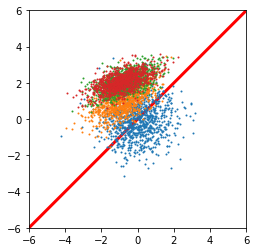

In [22]:
# CEIS_SG function call
## Parameter definition
mu_R = 10; sigma_R = 1.5
mu_S = 5; sigma_S = 2
R_pdf = ERADist('Lognormal','MOM',[mu_R, sigma_R])
S_pdf = ERADist('Gumbel','MOM',[mu_S,sigma_S])
# target distribution R,S are independent
f = lambda x: R_pdf.pdf(x[:,0])*S_pdf.pdf(x[:,1])# x Nxdim
# performance function g = R-S
g = lambda x: x[0,:]-x[1,:]# X: N:dim
# Threshold
gamma = 0
N_CE = 1000
p = 0.2
dim = 2
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [R_pdf, S_pdf]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
print("\nCE-based IS stage: ")
method = 'CE_SG'
if method == 'CE_SG':
    [Pr,lv,N_tot,gamma_hat,samplesU,samplesX,k_fin]=CEIS_SG(N_CE,p,g,T_Nataf)
# reference solution
Q_exact = 0.0331
# show p_f results
print("\n***Reference Pf: ",Q_exact," ***")
print("***CE-based IS Pf: ",Pr," ***\n")
# Plot samples
if dim == 2:
    nnp = 200
    xx = np.linspace(-6,6,nnp)
    [X,Y] = np.meshgrid(xx,xx)
    xnod = np.array([X,Y])
    Z = g(xnod)
    fig,ax = plt.subplots(subplot_kw={"aspect": "equal"})
    ax.contour(X,Y,Z,[0],colors='r',linewidths = 3)#LSF
    for sample in samplesU:
        ax.plot(*sample,".",markersize=2)
    plt.show()

## Importance sampling method
    # IS density is found by the improved CE method (iCE)

In [42]:
def approx_normCDF(x):
    # Return an approximation for the standard normal CDF based on a polynomial fit of degree 9
    erfun = np.zeros(len(x))
    idpos = x > 0
    idneg = x < 0
    t = (1+0.5*abs(x/np.sqrt(2)))**-1
    tau = t*np.exp(
        -((x/np.sqrt(2))**2)
        -1.26551223
        + 1.0000236 * t
        + 0.37409196 * (t ** 2)
        + 0.09678418 * (t ** 3)
        - 0.18628806 * (t ** 4)
        + 0.27886807 * (t ** 5)
        - 1.13520398 * (t ** 6)
        + 1.48851587 * (t ** 7)
        - 0.82215223 * (t ** 8)
        + 0.17087277 * (t ** 9)
    )
    erfun[idpos] = 1-tau[idpos]
    erfun[idneg] = tau[idneg] -1
    p = 0.5*(1+erfun)
    return p

In [51]:
## Improved Cross Entropy method self written
## Parameter definition
mu_R = 10; sigma_R= 1.5
mu_S = 5; sigma_S = 2
R_pdf = ERADist("Lognormal","MOM",[mu_R, sigma_R])
S_pdf = ERADist("Gumbel","MOM",[mu_S,sigma_S])
# target distribution
f = lambda x: R_pdf.pdf(x[:,0])*S_pdf.pdf(x[:,1])
# Performance function
# g = lambda R,S: R-S
g = lambda x: x[0,:]-x[1,:] # x has the size dimxN
# Threshold 
gamma = 0
N_iCE = 1000
p = 0.2
dim = 2
max_it = 50
CV_target = 1.5
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [R_pdf,S_pdf]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
print("\nCE-based IS stage: ")
#dim = len(T_Nataf)
u2x = lambda u: T_Nataf.U2X(u)
# LSF in standard space
G_LSF = lambda u: g(u2x(u))
# Initialization of variables and storage
N_tot = 0
# Definition of parameters of the random variables (uncorrelated standard normal)
mu_init = np.zeros(dim)
si_init = np.identity(dim)
sigma_t = np.zeros(max_it)
samplesU = list()
# CE procedure
# Initializing parameters
mu_hat = mu_init
si_hat = si_init
# Function reference
normalCDF = sp.stats.norm.cdf
minimize = sp.optimize.fminbound
# iteration 
for t in range(max_it):
    # Generate samples and save them
    U = sp.stats.multivariate_normal.rvs(mean = mu_hat,cov = si_hat,size = N_iCE).reshape(-1,dim)
    samplesU.append(U.T)
    # Count generated samples
    N_tot += N_iCE
    #Evaluation of the limit state function
    geval = G_LSF(U.T)
    # initialze sigma_0
    if j == 0:
        sigma_t[j] = 10*np.mean(geval)
    else:
        sigma_t[j] = sigma_new
    # Calculating h for the likelihood ratio
    h = sp.stats.multivariate_normal.pdf(U,mu_hat,si_hat)
    # Likelihood ratio 
    W = sp.stats.multivariate_normal.pdf(U,mean=np.zeros(dim),cov = np.identity(dim))/h
    # Indicator function
    I  =geval <= 0
    # Check convergence
    # Transitional weight W_t =h*(u)/h(u)=I(G(u)<=0)/normcdf(-G(u)/sigma_t), I*W when sigma_t approaches 0 
    W_approx = np.divide(I,approx_normCDF(-geval/sigma_t[j]))# weight o findicator approximation
    Cov_x = np.std(W_approx)/np.mean(W_approx)
    if Cov_x <= CV_target:
        break
    # compute sigma and weights for distribution fitting 
    # minimize COV of W_t ( W_t = approx_normCDF*W)
    fmin = lambda x: abs(
        np.std(np.multiply(approx_normCDF(-geval/x),W))
        /np.mean(np.multiply(approx_normCDF(-geval/x),W))
        -CV_target)
    sigma_new = minimize(fmin,0,sigma_t[j])
    # Update W_t 
    W_t = np.multiply(approx_normCDF(-geval/sigma_new),W)[:,None]
    # Parameter update : closed form update
    mu_hat = np.divide((W_t.T@U),sum(W_t)).flatten()
    Xo = np.multiply((U-mu_hat),np.sqrt(W_t))
    si_hat = np.divide((Xo.T@Xo),sum(W_t))+1e-6*np.identity(dim)
    
# needed steps
lv = t
# Calculation of the probability of failure
Pr = 1/N_iCE *sum(W[I])
# transfor the samples to the physical space
samplesX = list()
for i in range(lv): 
    samplesX.append(u2x(samplesU[i]))
#return Pr, lv, N_tot, samplesU, samplesX


CE-based IS stage: 



***Reference Pf:  0.0331  ***
***CE-based IS Pf:  0.034581796256473715  ***



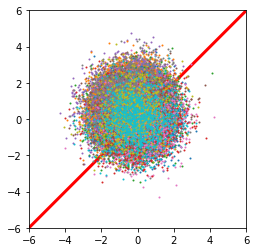

In [52]:
# reference solution
Q_exact = 0.0331
# show p_f results
print("\n***Reference Pf: ", Q_exact, " ***")
print("***CE-based IS Pf: ", Pr, " ***\n")
# Plot samples
if dim == 2:
    nnp = 200
    xx = np.linspace(-6, 6, nnp)
    [X, Y] = np.meshgrid(xx, xx)
    xnod = np.array([X, Y])
    Z = g(xnod)

    fig, ax = plt.subplots(subplot_kw={"aspect": "equal"})
    ax.contour(X, Y, Z, [0], colors="r", linewidths=3)  # LSF
    for sample in samplesU:
        ax.plot(*sample, ".", markersize=2)
    plt.show()

Improved Cross Entropy Self version


CE-based IS stage: 

***Reference Pf:  0.0331  ***
***CE-based IS Pf:  0.03184653062407222  ***



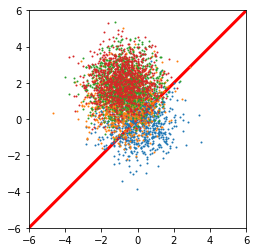

In [3]:
## Improved Cross Entropy method self written
## Parameter definition
mu_R = 10; sigma_R= 1.5
mu_S = 5; sigma_S = 2
R_pdf = ERADist("Lognormal","MOM",[mu_R, sigma_R])
S_pdf = ERADist("Gumbel","MOM",[mu_S,sigma_S])
# target distribution
f = lambda x: R_pdf.pdf(x[:,0])*S_pdf.pdf(x[:,1])
# Performance function
# g = lambda R,S: R-S
g = lambda x: x[0,:]-x[1,:] # x has the size dimxN
# Threshold 
gamma = 0
N_iCE = 1000
p = 0.2
dim = 2
max_it = 50
CV_target = 1.5
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [R_pdf,S_pdf]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
print("\nCE-based IS stage: ")
G_LSF = lambda u: g(T_Nataf.U2X(u))
# Initialization of variables and storage
N_tot = 0 # Total number of samples
# Definition of parameters of the random variables
mu_init = np.zeros(dim)
si_init = np.identity(dim)
sigma_t = np.zeros(max_it)
samplesU = list()
# CE rpocedure
mu_U = mu_init
si_U = si_init
# Funct
# Iteration
for t in range(max_it):
    # Generate samples and save them
    U = sp.stats.multivariate_normal.rvs(mean=mu_U,cov = si_U,size = N_iCE).reshape(-1,dim)
    samplesU.append(U.T)
    # Count generated samples
    N_tot += N_iCE
    # Evaluate the limit state funciton
    geval = G_LSF(U.T)
    # initialize sigma_0
    if t==0:
        sigma_t[t] = 10 * np.mean(geval)
    else:
        sigma_t[t] = sigma_new
    # Calculating h for the likelihood ratio
    h = sp.stats.multivariate_normal.pdf(U,mu_U,si_U)
    phi = sp.stats.multivariate_normal.pdf(U,mean=np.zeros(dim),cov = np.identity(dim))
    # likelihood ratio for the original CE weight
    W = phi/h
    # Indicator function
    I = geval <= 0
    # iCE weight W_t = I*W    W_t = h*/h_t  = (I*phi/PF)/(It*phi/PFt) = (I/PF)/(It/PFt) proportional to I/It = I / (phi(-G/(sigma_t))
    W_t = I*W
    # CV of W_t
    delta_Wt = np.std(W_t)/np.mean(W_t)
    if delta_Wt <= CV_target:
        break
    # solve the optimization problem
    I_fun = lambda sigma: sp.stats.norm.cdf(-geval/sigma)
    Wt_fun = lambda sigma: I_fun(sigma)*W
    CV_Wt_fun = lambda sigma :np.std(Wt_fun(sigma))/np.mean(Wt_fun(sigma))
    fmin = lambda sigma: abs(CV_Wt_fun(sigma)-CV_target)
    sigma_new = sp.optimize.fminbound(fmin,0,sigma_t[t])
    # Update W_t 
    W_t = Wt_fun(sigma_new)
    # Parameter update: closed form update
    mu_U = W_t @ U / sum(W_t) 
    Xtmp = U-mu_U 
    Xo = Xtmp * np.tile(np.sqrt(W_t),(dim,1)).T
    Si_U = np.matmul(Xo.T,Xo)/np.sum(W_t)+1e-6*np.identity(dim)
# total levels
lv = t
# calculation of the probability of failures
Pr = 1 / N_iCE * sum(W[I])
# Pr = 1 / N_iCE * sum(W_t) 
# transform the samples to the physical/original space
samplesX = list()
for i in range(lv):
    samplesX.append(T_Nataf.U2X(samplesU[i]))
# reference solution
Q_exact = 0.0331
# show p_f results
print("\n***Reference Pf: ", Q_exact, " ***")
print("***CE-based IS Pf: ", Pr, " ***\n")
# Plot samples
if dim == 2:
    nnp = 200
    xx = np.linspace(-6, 6, nnp)
    [X, Y] = np.meshgrid(xx, xx)
    xnod = np.array([X, Y])
    Z = g(xnod)

    fig, ax = plt.subplots(subplot_kw={"aspect": "equal"})
    ax.contour(X, Y, Z, [0], colors="r", linewidths=3)  # LSF
    for sample in samplesU:
        ax.plot(*sample, ".", markersize=2)
    plt.show()

In [4]:
sigma_t

array([4.96026107e+01, 2.93369516e+00, 8.13125097e-01, 4.28541384e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [6]:
sigma_t

array([4.96026107e+01, 2.93369516e+00, 8.13125097e-01, 4.28541384e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [4]:
I.shape

(1000,)

In [11]:
(W*I).shape

(1000,)

In [6]:
Pr = 1 / N_iCE * sum(W_t)
Pr

0.03251787062491083

In [7]:
U .shape

(1000, 2)

In [8]:
W_t.T @U

array([-29.73138327,  65.89539306])

In [9]:
W_t @U

array([-29.73138327,  65.89539306])

In [82]:
np.multiply((U-mu_hat) ,np.sqrt(W_t))

ValueError: operands could not be broadcast together with shapes (1000,2) (1000,) 

In [84]:
np.sqrt(W_t).shape

(1000,)

## Subset simulation method

In [31]:
## Subset simulation method 
# Since we need to do the simulation in the standard normal space we need Nataf transformation
# to transform the Inputs in the physical space to the mean=0, Cov = indentity matrix multivariate standard normal space
dim = 2
# Set up the Nataf distribution object
mu_R = 10; sigma_R= 1.5;
mu_S = 5; sigma_S = 2;Q_exact
R_pdf = ERADist("Lognormal","MOM",[mu_R, sigma_R])
S_pdf = ERADist("Gumbel","MOM",[mu_S,sigma_S])
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [ERADist("Lognormal","MOM",[mu_R, sigma_R]),ERADist("Gumbel","MOM",[mu_S,sigma_S])]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
# target distribution
f = lambda x: R_pdf.pdf(x[:,0])*S_pdf.pdf(x[:,1])
# number of samples per level
N_SuS = 1000
# Quantile
p = 0.3
# Correlation parameter for the conditional sampling M-H
rho = 0.8
# Generate samples at the first level ~ standard multi-normal distribution
u_SuS = sp.stats.multivariate_normal.rvs(0,1,(N_SuS,dim)) #dimxN_SuS
# Generate samples in the original space
x_SuS = np.transpose(T_Nataf.U2X(np.transpose(u_SuS)))# N_SuS xdim
# Evaluate the responses# g = lambda R,S: R-S
#g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
g_SuS = g(x_SuS)
maxT = 100
for t in range(maxT):
    # Sort the responses
    g_SuS_sort = np.sort(g_SuS)
    # Estimate gamma_t
    gamma_t = max(g_SuS_sort[int(p*N_SuS)],gamma)

    #gamma_t = np.nanpercentile(g_SuS,p*100)
    #gamma_t = max(gamma_t,gamma)
    # Check if the final level is reached
    if gamma_t == gamma:
        break
    print("\nIntermediate failure threshold: ",gamma_hat[t+1])
    # set seeds for conditional MCMC
    I_SuS = g_SuS < gamma_t
    u_seed = u_SuS[I_SuS,:]
    g_seed = g_SuS[I_SuS]
    # Number of seeds
    N_seed = sum(I_SuS)
    # Length of each chain
    N_Chain = np.floor(N_SuS/N_seed)*np.ones((N_seed,1))
    N_Chain[1:np.mod(N_SuS,N_seed)] = N_Chain[1:np.mod(N_SuS, N_seed)]+1
    # Conditional sampling M-H algorithm
    count = 0
    for i in range(N_seed):
        count = count+1
        u_SuS[count,:] = u_seed[i,:]
        g_SuS[count] = g_seed[i]
        
        for j in range(int(N_Chain[i])-1):
            count = count+1
            # generate candidate state
            #Corr_z = (1-np.power(rho,2))*np.identity(dim)
            #z = sp.stats.multivariate_normal.rvs([0,0],Corr_z,(dim,1))
            z = sp.stats.norm.rvs(0,np.sqrt(1-np.power(rho,2)),(dim,1))
            u_cand = rho*u_SuS[count-1,:]+np.transpose(z)
            # candidate samples at the pyhsical space
            x_cand = np.transpose(T_Nataf.U2X(np.transpose(u_cand)))# u: dimxN; x: Nxdim
            # Evaluate the responses 
            g_cand = g(x_cand)
            # accept or reject 
            if g_cand < gamma_t:
                u_SuS[count,:] = u_cand
                g_SuS[count] = g_cand
            else:
                u_SuS[count,:] = u_SuS[count-1,:]
                g_SuS[count] = g_SuS[count-1]
            
# Total number of levels
T_SuS = t+1
# Evaluation of Pr(g_SuS<0)
I_SuS = g_SuS < gamma
Q_SuS = (np.power(p,(T_SuS-1)))*sum(I_SuS)/N_SuS
Q_SuS


Intermediate failure threshold:  4.979822372132402

Intermediate failure threshold:  0.0


0.030869999999999998

In [32]:
N_seed

300

In [33]:
## Importance sampling method (Choose the IS density through the cross entropy method)
# IS density using the cross entropy method
# number of samples per level
N_CE = 1000
# Quantile value to select samples for parameter update
p = 0.3
# limit state function in physical space
g = lambda x: x[:,0]-x[:,1] # x has the size Nxdim
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [ERADist("Lognormal","MOM",[mu_R, sigma_R]),ERADist("Gumbel","MOM",[mu_S,sigma_S])]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
dim = len(T_Nataf.Marginals)
u2x = lambda u: T_Nataf.U2X(u)
# Limist state function in standard space
G_LSF = lambda u: g(u2x(u))
# Initialization of variables and storage
j = 0 # initial level
maxT = 50 # estimated number of iterations
N_tot = 0 # total number of samples
# Definition of parameters of the random variables (uncorrelated standard normal)
mu_init = np.zeros(dim)
Si_init = np.eye(dim)
gamma_hat = np.zeros((maxT + 1))
samplesU = list()
# CE procedure
# Initial parameters
gamma_hat[j]=1
mu_hat = mu_init
Si_hat = Si_init
# Iteration
for j in range(maxT):
    # Generate samples and save them
    X = sp.stats.multivariate_normal.rvs(mean = mu_hat,cov = Si_hat, size=N_CE).reshape(-1,dim)
    samplesU.append(X.T)
    # Count generated samples
    N_tot +=N_CE
    # Evaluate the limit state funtion
    geval = G_LSF(X.T)
    # Calculating h for the likelihood funtion
    h = sp.stats.multivariate_normal.pdf(X,mu_hat,Si_hat)
    # Check convergence
    if gamma_hat[j]==0:
        break
    # obtaining estimator gamma
    gamma_hat[j+1]=np.maximum(0,np.nanpercentile(geval,p*100))
    print("\nIntermediate failure threshold: ",gamma_hat[j+1])
    # Indicator function
    I = geval <= gamma_hat[j+1]
    # Likelihood ratio
    W = (sp.stats.multivariate_normal.pdf(X,mean=np.zeros((dim)),cov = np.eye(dim))/h)
    # Parameter update: Closed-form update
    prod = np.matmul(W[I],X[I,:])


Intermediate failure threshold:  1.089590122580395


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 2

In [42]:
a = np.ones([9,5,7,4])
a

array([[[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         ...,
         [1.,

In [43]:
c = np.ones([9,5,4,3])
c

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [

In [45]:
np.matmul(a,c).shape

(9, 5, 7, 3)

In [47]:
np.dot(a,c).shape

(9, 5, 7, 9, 5, 3)

In [35]:
'''
 CE-SG function
 ------------------------------
 # Inputs: 
 ## N: number of samples per level
 ## N_final: number of samples for the last step
 ## p: quantile value to select samples for paremeter update
 ## g_fun: limit state funtion, assume the input samples has the size Nxdim
 ## distr: Nataf distribution object or marginal distribution object of the input variables
 -------------------------------
 # Outputs:
 ## Pr: Probability of failure
 ## T: total number of levels
 ## N_tot : total number of samples
 ## gamma_hat: intermediate levels
 ## samplesU: the samples in the standard normal space
 ## samplesX: the samples in the standard normal space
 ## kfin: final number of Gaussians in the mixture
'''

def CEIS_SG (N,N_final,p,g_fun,distr):
    # iniital check if there exits a Nataf object
    if isinstance(distr,ERANataf):# use Nataf transform (dependence)
        dim = len(distr.Marginals) # number of random variables (dimensiton)
        u2x = lambda u: distr.U2X(u) # from u to x
    elif isinstance(distr[0],ERADist):# use distribution information for the transformation (independence)
        # Here we assume that all the parameters have the same distribution!!!, if not adjust accordingly
        dim = len(distr)# number of random variables (dimension)
        u2x = lambda u: distr[0].icdf(sp.stats.norm.cdf(u))# from u to x
    else:
        raise RuntimeError("Incorrect distribution. Please create an ERADist/Nataf object!")
    # LSF in the standard space
    G_LSF = lambda u: g_fun(u2x(u))
    #Initialization of variables and storages
    t = 0# initial level
    maxT = 100 # estimated number of iterations
    N_tot = 0 # total number of samples
    # Definition of parameters of the random variables in the standard normal space (uncorrelated standard normal )
    mu_init = np.zeros(dim)
    Si_init = np.identity(dim)
    gamma_hat = np.zeros(maxT+1)
    samplesU = list()
    # CE Procedure
    # Initializing parameters
    gamma_hat[t] = 1
    mu_U = mu_init
    Si_U =  Si_init
    # Iterations
    for t in range(maxT):
        U = sp.stats.multivariate_normal.rvs(mean=mu_U,cov=Si_U,size=N).reshape(-1,dim)# U_samples has the size Nxdim
        samplesU.append(U)
        # count generated samples
        N_tot +=N
        # Caluculating h for the likelihood ratio
        h = sp.stats.multivariate_normal.pdf(U,mu_U,Si_U)
        # Likelihood ratio
        f = sp.stats.multivariate_normal.pdf(U,mean=np.zeros(dim),cov = np.identity(dim))
        W = f/h
        # check convergence
        if gamma_hat[t] == 0:
            break

        # Indicator funciton
        # Evaluate the limit state function
        geval = G_LSF(U.T)
        I = geval<=gamma_hat[t+1]
        # obtaining estimator gamma
        gamma_hat[t+1] = np.maximum(0,np.nanpercentile(geval,p*100))
        print("\nItermediate failure threshold: ",gamma_hat[t+1])
        # parameter update
        prod  = np.matmul(W[I],U[I,:])
        summ = np.sum(W[I])
        mu_U = prod/summ
        Utmp = U[I,:]-mu_U
        Xo = (Utmp)*np.tile(np.sqrt(W[I]),(dim,1)).T
        Si_U = np.matmul(Xo.T,Xo)/np.sum(W[I])+1e-6*np.identity(dim)
    # total steps
    T = t+1
    #gamma_hat = gamma_hat [:,T+1]
    # generate samples according to the obtained IS density
    U_final = sp.stats.multivariate_normal.rvs(mean=mu_U,cov=Si_U,size=N_final).reshape(-1,dim)
    # Caluculating h for the likelihood ratio
    h_final = sp.stats.multivariate_normal.pdf(U_final,mu_U,Si_U)
    # Likelihood ratio
    f_final = sp.stats.multivariate_normal.pdf(U_final,mean=np.zeros(dim),cov = np.identity(dim))
    # Calculate the probability of failure
    W_final = f_final/h_final
    g_final = G_LSF(U_final)
    I_final = g_final <= 0
    Pr = sum(I_final*W_final)/N_final
    k_fin = 1
    # transform to the physical space
    samplesX = list()
    for i in range(T):
        samplesX.append(u2x(samplesU[i][:,:]))
    return Pr, T, N_tot, samplesU, samplesX
# Inputs: 
 ## N: number of samples per level
N_CE = 1000
 ## N_final: number of samples for the last step
N_final = 1000
 ## p: quantile value to select samples for paremeter update
p = 0.3
 ## g_fun: limit state funtion, assume the input samples has the size Nxdim
g = lambda x: x[0,:]-x[1:,] # x has the size Nxdim
 ## distr: Nataf distribution object or marginal distribution object of the input variables
## Parameter definition
mu_R = 10; sigma_R= 1.5
mu_S = 5; sigma_S = 2
R_pdf = ERADist("Lognormal","MOM",[mu_R, sigma_R])
S_pdf = ERADist("Gumbel","MOM",[mu_S,sigma_S])
dim = 2
# distribution Nataf object or marginal distribution of the input variables in physical space
M = [R_pdf,S_pdf]
Rho = np.identity(dim)
# Apply the Nataf transformation
T_Nataf = ERANataf(M,Rho)
[Pr,lv,N_tot,samplesU,samplesX] = CEIS_SG(N_CE,N_final,p,g,T_Nataf)
# show p_f results
print("\n***Reference Pf: ",Q_exact," ***")
print("***CE-based IS Pf: ",Pr," ***\n")
# Plot samples
if dim == 2:
    nnp = 200
    xx = np.linspace(-6,6,nnp)
    [X,Y] = np.meshgrid(xx,xx)
    xnod = np.array([X,Y])
    Z = g(xnod)
    fig, ax = plt.subplots(subplot_kw = {"aspect": "equal"})
    ax.contour(X,Y,Z,[0],colors = 'r',linewidths = 3)#LSF
    for sample in samplesU:
        ax.plot(*sample,".",markersize = 2)
    plt.show()


Itermediate failure threshold:  3.9343197675235135


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed